In [1]:
import codecs, json, glob, os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report, f1_score
import numpy as np
import pandas as pd
from tqdm import tqdm

from generator import label_mapping
from utils.image_processing import read_resize

from utils.plotting import plot_image_label_prediction, plot_uncertainty_heatmaps, \
    plot_uncertainty_statistics, plot_image, plot_label, plot_predictions

VALIDATION_RESULT_DIR = "/media/olle/3DCPC/oct_segmentation/cv_runs/validation_model_results"

models = os.listdir(VALIDATION_RESULT_DIR)

configured_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15]


## load json files to evaluate

In [3]:
def read_decode_json(file_path):
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    
    json_result_file = json.loads(obj_text)
    
    image = np.array(json_result_file["image"])
    prediction = np.array(json_result_file["prediction"])
    
    if len(image.shape) > 3:
        image = image[0, :, :, :]
        
    if len(prediction.shape) > 2:
        prediction = prediction[0, :, :]
    
    json_result_file["image"] = image
    json_result_file["label"] = np.array(json_result_file["label"])
    json_result_file["prediction"] = prediction
    return json_result_file

def read_results(model):
    # set paths
    model_dir = os.path.join(VALIDATION_RESULT_DIR, model)
    json_result_paths = glob.glob(model_dir + f"/*.json")

    result_jsons = {}
    
    for json_file_path in json_result_paths:
        record = json_file_path.split("/")[-1].replace(".json", "")
        
        if "model" in record:
            continue
            
        result_jsons[record] = read_decode_json(json_file_path)
    return result_jsons
        
def plot_results(result_jsons, model):
    records = result_jsons.keys()
    
    model_dir = os.path.join(VALIDATION_RESULT_DIR, model)

    for record in records:
        record_log = result_jsons[record]
        data = [record_log["image"], record_log["label"], record_log["prediction"]]

        # all plotting functions
        plot_image_label_prediction(data, model_dir = model_dir, filename=record, mode="test")
        plot_image(record_log["image"], model_dir = model_dir, filename=record, mode="test")
        plot_label(record_log["label"], model_dir = model_dir, filename=record, mode="test")
        plot_predictions([record_log["prediction"]], model_dir = model_dir, filename=record, mode="test")
        
        
def get_results(result_jsons):
    records = result_jsons.keys()

    f1_record_log = {}
    f1_total_log = {}

    all_labels = []
    all_predictions = []

    for record in records:
        record_log = result_jsons[record]

        labels = record_log["label"].flatten()
        predictions = record_log["prediction"].flatten()

        all_labels.extend(labels.tolist())
        all_predictions.extend(predictions.tolist())

        f1_record_log[record] = f1_score(labels, 
                             predictions, 
                             average = None, 
                             labels = configured_labels, 
                             zero_division=1)

    # calculate for each log
    f1_total_log = f1_score(all_labels, 
                            all_predictions, 
                            average = None, 
                            labels = configured_labels, 
                            zero_division=1)

    # convert to data frames for plotting
    total_f1_pd = pd.DataFrame(f1_total_log).T.replace(1.0, np.NaN)
    record_f1_pd = pd.DataFrame(f1_record_log).T.replace(1.0, np.NaN)
    
    return total_f1_pd, record_f1_pd

In [13]:
columns = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
validation_log = pd.DataFrame(columns=columns)

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import time

def fill_validation_log(model):
    print(model)
    jsons = read_results(model)
    total_r, record_r = get_results(jsons)
    return total_r

In [14]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=6, verbose=1, backend="multiprocessing")(map(delayed(fill_validation_log), 
                                                                       models))

585216173639830462465590
674516
303462





[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.


44799
914186
189758
979510
650250
843899
245095
936922
700100641439

255300
364699
238348
939259
606552
384874
194748
857508
647804
258963
218485
605590
66039
652672
881994
224404
856325
725761
572888
777069
555051
936797
237440
626239
155339
188259
380653
281123


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.1min


976626
592740
730499
329095
58738
420552
811869
453381
207372
842047
97643
589566
821982
685293
56938
895181
45101
813803
700978
56263
3222
214715
777231
765228
370520
123335
398719
301676
1649
552354
34012
337371
913786
415941
88448
867204
566128
350107
410553
32127
809396
229694
420256
109752
993522
148080
67774
954653
589392
126011
140200
229876
542924
33961
380613
444869
364297
81462
946297
67013
873193
430194
138101
445218
104592
699196
982119
232340
555835
951566
514120
377191
696056
601191
806972
424795
659672
447321
673739
535348
652903
241542
748794
6040
882141
168030
233112
294455
354152
360421
429141
536581
533641
731621
14220
174640
911685
727121
458024
897386
665424
786955
457632
6605
158622
341897
499642
108937
814402
954822
267457
795234
855493
987522
863601
199203
947220
296094
611345
764936
903506
627826
349324
907673
536757
376828
519020
27062
230563
326116
925529
357031
318584
240413
503788
470972
138617
351297
596024
429420
248846
244056
773561
213178
607804
340171


[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 20.7min


811322
745403
216651
875465
965169
496689
455534
788396
404565
101820
83018
411527
262273
677274
341236
209849
235936
737024
966886
651321457641

737613
400373
680321
63667
153306
159659
136199
673040
528033
721646
555221
145112
20444
760679
904653
438878
541459
109595
485447
423550
459509
14574
75921
249919
670693
369078
995748
783466
638410
544838
799464
510050
199003
793203
222982
547850
470090
33984
570011
428377
748455
429482
808050
706396
341443
330991
776303
349660
632234
968033
133330
198160
845351
178289
992758
483186
770833
46673
634771
678529
240123
898597
515217
665264
88642


[Parallel(n_jobs=6)]: Done 280 out of 280 | elapsed: 28.9min finished


In [15]:
columns = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
validation_log = pd.DataFrame(columns=columns)

for i in range(len(results)):
    validation_log = validation_log.append(pd.DataFrame(results[i]))
    
validation_log["model"] = models

# sort by ambig features
validation_log["sort_feature"] = validation_log[[8, 5]].mean(1)
validation_log = validation_log.sort_values(by="sort_feature", ascending=False)

In [ ]:
## plot perf difference in 5, 8, 11, and total

In [ ]:
validation_five = validation_log_long[validation_log_long.feature.isin([5])]


In [22]:
## plot results

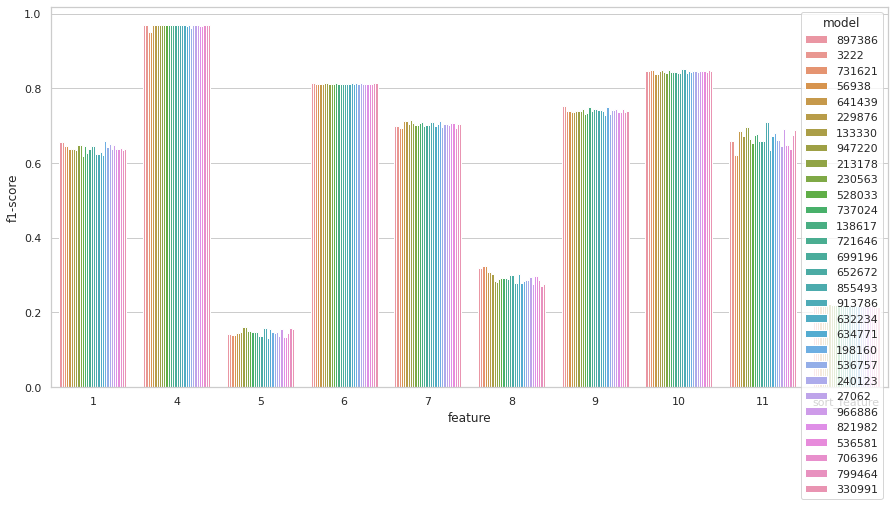

In [17]:
NUM_COMPARE = 30
validation_log_long = pd.melt(validation_log.iloc[0:NUM_COMPARE], id_vars="model")
validation_log_long = validation_log_long.rename(columns={"variable": "feature", "value":"f1-score"})

validation_log_long = validation_log_long[~validation_log_long.feature.isin([0, 3, 2, 12, 13])]
import seaborn as sns
sns.set(rc={'figure.figsize':(15,7)})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="feature", y="f1-score", hue="model", data=validation_log_long)


## Get model paths

In [18]:
selected_models = validation_log.iloc[0:NUM_COMPARE].model.tolist()

model_files = []
for sel_model in selected_models:
    model_json = os.path.join(VALIDATION_RESULT_DIR, sel_model, "model.json")
    # Opening JSON file
    f = open(model_json)

    # returns JSON object as 
    # a dictionary
    data = json.load(f)
    model_files.append(data["model_path"])
    
model_files   

['/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_1/1745_L_20180706_640469001_46/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_1/1745_L_20180706_640469001_46/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_1/338917_L_20160927_492116001_32/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_1/338917_L_20160927_492116001_32/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_3/24844_R_20170502/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_3/24844_R_20170502/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs/logs_0/43106_R_20141111/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_1/333295_R_20170517/model.h5',
 '/media/olle/3DCPC/oct_segmentation/cv_runs/cross_validation_runs0/logs_0/135590_L_20171201_586379001_17/model.h5',
 '/medi